In [ ]:
#catch issues early (all-padding, werid lengths, empty families) and confirm your max_len choice is sensible
'''
	1.	Are raw sequence lengths sensible? (so your max_len isn’t too small/too large)
	2.	Do all encoded files load and have consistent shapes/dtypes?
	3.	How much padding did we introduce? (padding ratio)
	4.	Per-family counts (did filters silently wipe out a family?)
    
    Imports:
	•	json → loads your cleaned protein sequences (proteins.json).
	•	glob, os, Path → help you navigate folders and find all your .pt files.
	•	numpy → gives statistical functions like mean, percentile, etc.
	•	matplotlib.pyplot → plots histograms.
	•	torch → reads the encoded PyTorch tensors (.pt files).
	•	Paths:
	•	RAW_JSON points to your cleaned data (output from Step 3).
	•	ENC_DIR points to your encoded tensors (output from Step 4).
'''
import json, glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch

RAW_JSON = "../data/processed/proteins.json"
ENC_DIR = "../data/encoded"


Matplotlib is building the font cache; this may take a moment.


In [ ]:
#Loading raw lengths 
'''
We want to know how long your proteins actually are, because that determines the model’s max_len.
If you pad too short, you truncate important motifs; too long, you waste compute.
The 95th percentile is a sweet spot that keeps ~95 % of proteins intact while reducing padding waste.
'''   
data = json.load(open(RAW_JSON))
lengths = []
for fam in data.values():
    for s in fam:
        lengths.append(len(s))

print(f"Families: {len(data)}  | Total_sequences: {sum(len(v) for v in data.values())}")
print(f"min: {np.min(lengths)}, mean: {round(np.mean(lengths), 1)} , median: {np.median(lengths)} , p95: {np.percentile(lengths, 95)} , max: {np.max(lengths)}")

Families: 16  | Total_sequences: 16
min: 115, mean: 777.5 , median: 627.0 , p95: 1897.75 , max: 2569


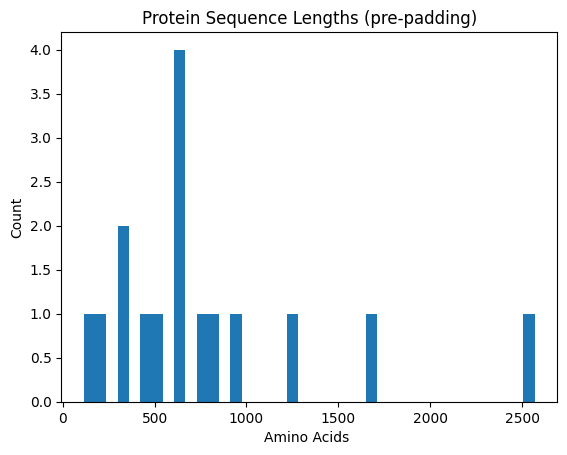

In [ ]:
#Histograms
#If you see a long tail, you might have a few huge outlier proteins.
#If everything clusters around a single range (e.g., 200–300 aa), you can safely pad to ~400.

plt.hist(lengths, bins=40)
plt.title("Protein Sequence Lengths (pre-padding)")
plt.xlabel("Amino Acids ")
plt.ylabel("Count")
plt.show() #displays it inline with the notebook

In [ ]:
#padding ratio across encoded tensors
'''
looping through every encoded family file (.pt)
loading the tensor -> each sequence has length = 400 (we padded in encode.py)
Counts:
    total = all positions in all sequences
    pads = how many of those positions are padding
divides to get the padding ratio

The padding ratio tells you how much of your data is real signal vs. empty filler:
	•	≈ 0.3–0.5 → good balance.
	•	> 0.7 → too much wasted padding → consider smaller max_len.
	•	< 0.1 → maybe truncating proteins → increase max_len.
This is to basically make sure we are learning from amino acids and not zeros
'''

paths = glob.glob(os.path.join(ENC_DIR, "*.pt"))
total, pads = 0,0
for p in paths:
    pack = torch.load(p)
    if isinstance(pack, dict):
        X = pack["X"]
    else:
        if len(pack) == 0: #skip empty lists
            print(f"Skipping {p} : no sequences found")
            #remember when changing ranges that you must rerun parse_fasta AND encode from utils
            continue
        X = torch.stack(pack)
    total += X.numel()
    pads += (X == 0).sum().item()
print("Overall padding ratio:", round(pads/total, 3))




Overall padding ratio: 0.741


In [16]:
# Per family stats with pandas
import pandas as pd

'''
	•	Loops through each family file.
	•	Records:
	•	fam = family name
	•	n = number of proteins in that family
	•	L = length after padding
	•	PadRatio = fraction of padding inside that file
	•	Builds a pandas DataFrame (a spreadsheet-like table).
	•	Shows the 10 families with the highest pad ratios.

    This helps you spot outlier families
    - maybe one family has much shorter proteins than others -> almost all padding
    - maybe another has too few sequences (filtered too hard)
    - You can later decide to rebalance or drop such families for fairer few-shot learning.


'''

rows = []
for p in paths: #looping through every family file
    fam = Path(p).stem #fam = family name
    pack = torch.load(p)
    if isinstance(pack, dict):
        X = pack["X"]
    else:
        if len(pack) == 0: #skip empty lists
            print(f"Skipping {p} : no sequences found")
            #remember when changing ranges that you must rerun parse_fasta AND encode from utils
            continue
        X = torch.stack(pack)
    n, L = X.shape
    pad = (X == 0).sum().item() / X.numel()
    rows.append((fam, n, L, pad))

df = pd.DataFrame(rows, columns=["Family", "N", "L", "PadRatio"])
df.sort_values("PadRatio", ascending=False) #.head(10) to show only 10


,Family,N,L,PadRatio
3,Dehydrogenase,1,3000,0.961667
6,SCP,1,3000,0.937000
5,C2H2,1,3000,0.897000
14,Immunoglobulin,1,3000,0.892000
7,ATP-Synthase,1,3000,0.845333
1,Peptidase,1,3000,0.819000
2,BipA-Ribosomal,1,3000,0.796333
9,Kinase,1,3000,0.791667
13,AMP-binding,1,3000,0.790333
12,Cytochrome,1,3000,0.784000


What Padding Ratio Means

When you encode sequences, every protein gets padded (with 0s) or truncated to the same fixed length (max_len, say 400 amino acids).
Not all proteins are exactly 400 amino acids long — some are shorter, some longer — so padding fills the empty space.

Padding ratio measures how much of your data tensor is made up of padding vs. real amino acids.

Imagine:
	•	You set max_len = 400
	•	Your average protein length = 200
→ That means half your sequence is zeros ⇒ padding ratio ≈ 0.5.

If your ratio were 0.9, 90% of your input tokens are zeros, and only 10% carry information — the model spends most of its compute “learning nothing.”

Why It Matters Biologically

Protein sequences vary widely:
	•	Enzymes might be 300–600 amino acids.
	•	Small peptides might be 40–80 amino acids.

If your dataset mixes both, short families get a ton of padding, and their motifs get “drowned out” in zeros.
A balanced padding ratio ensures each protein contributes meaningful signal to the network.

After your inspection notebook finishes:
	1.	Look at your printed “Overall padding ratio” number.
	2.	Interpret it with the table above.
	•	If it’s between 0.2–0.5, you’re golden.
	•	If it’s high (>0.7), re-run Step 4 with a smaller max_len.
	•	If it’s low (<0.1), re-run Step 4 with a larger max_len.
	3.	(Optional) Re-inspect the histogram: confirm most sequences fit within your chosen range.

In [15]:
plt.savefig("../results/length_hist.png", dpi=160)
df.to_csv("../results/family_stats.csv", index=False)

<Figure size 640x480 with 0 Axes>